Con base en sector, temática y dataset seleccionados:

Aplicar: 

- Mínimos cuadrados
- Regresión Lineal, Múltiple
- Anova
- Varianza

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('IMDB_cleaned.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683785 entries, 0 to 683784
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 683785 non-null  int64  
 1   title              683785 non-null  object 
 2   vote_average       683785 non-null  float64
 3   vote_count         683785 non-null  int64  
 4   status             683785 non-null  object 
 5   release_date       683785 non-null  object 
 6   revenue            683785 non-null  int64  
 7   runtime            683785 non-null  int64  
 8   adult              683785 non-null  bool   
 9   budget             683785 non-null  int64  
 10  original_language  683785 non-null  object 
 11  original_title     683785 non-null  object 
 12  popularity         683785 non-null  float64
 13  genres             683785 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 68.5+ MB


In [7]:
# Exploración inicial del dataset para entender las variables
print("Primeras 5 filas del dataset:")
print(df.head())
print("\nEstadísticas descriptivas:")
print(df.describe())


Primeras 5 filas del dataset:
       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult     budget original_language   original_title  \
0   825532764      148  False  160000000                en        Inception   
1   701729206      169  False  165000000                en     Interstellar   
2  1004558444      152  False  185000000                en  The Dark Knight   
3  2923706026      162  False  237000000                en           Avatar   
4  1518815515      143  False  220000000                en     The Avengers   

   popularity       

Análisis de la variable 'revenue':
Valores únicos: 14022
Valores con revenue = 0: 664710
Porcentaje con revenue = 0: 97.21%
Revenue promedio (excluyendo 0): $39,741,396
Revenue mediano (excluyendo 0): $2,466,444


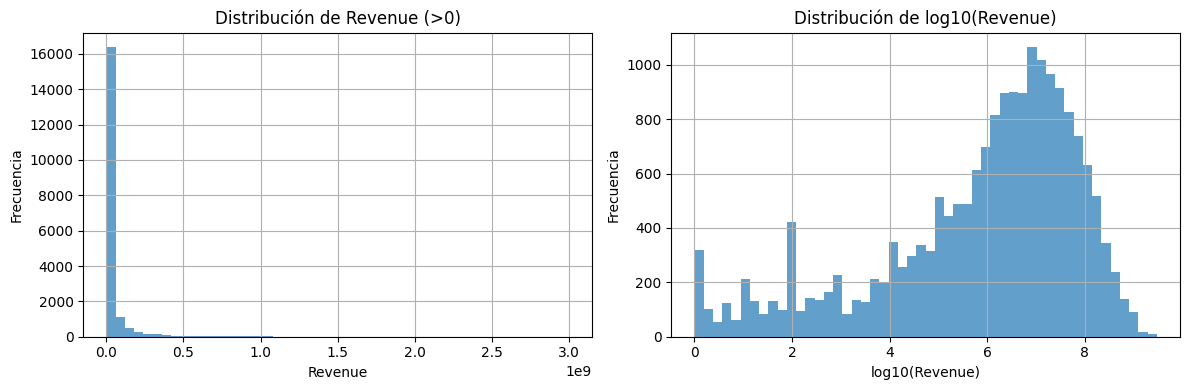

In [8]:
# Análisis de la variable objetivo 'revenue'
print("Análisis de la variable 'revenue':")
print(f"Valores únicos: {df['revenue'].nunique()}")
print(f"Valores con revenue = 0: {(df['revenue'] == 0).sum()}")
print(f"Porcentaje con revenue = 0: {(df['revenue'] == 0).mean() * 100:.2f}%")
print(f"Revenue promedio (excluyendo 0): ${df[df['revenue'] > 0]['revenue'].mean():,.0f}")
print(f"Revenue mediano (excluyendo 0): ${df[df['revenue'] > 0]['revenue'].median():,.0f}")

# Distribución de revenue
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df[df['revenue'] > 0]['revenue'].hist(bins=50, alpha=0.7)
plt.title('Distribución de Revenue (>0)')
plt.xlabel('Revenue')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df[df['revenue'] > 0]['revenue'].apply(lambda x: np.log10(x)).hist(bins=50, alpha=0.7)
plt.title('Distribución de log10(Revenue)')
plt.xlabel('log10(Revenue)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


Correlaciones con revenue (solo películas con revenue > 0):
revenue         1.000000
budget          0.723815
vote_count      0.695891
popularity      0.232437
runtime         0.157185
vote_average    0.120974
Name: revenue, dtype: float64


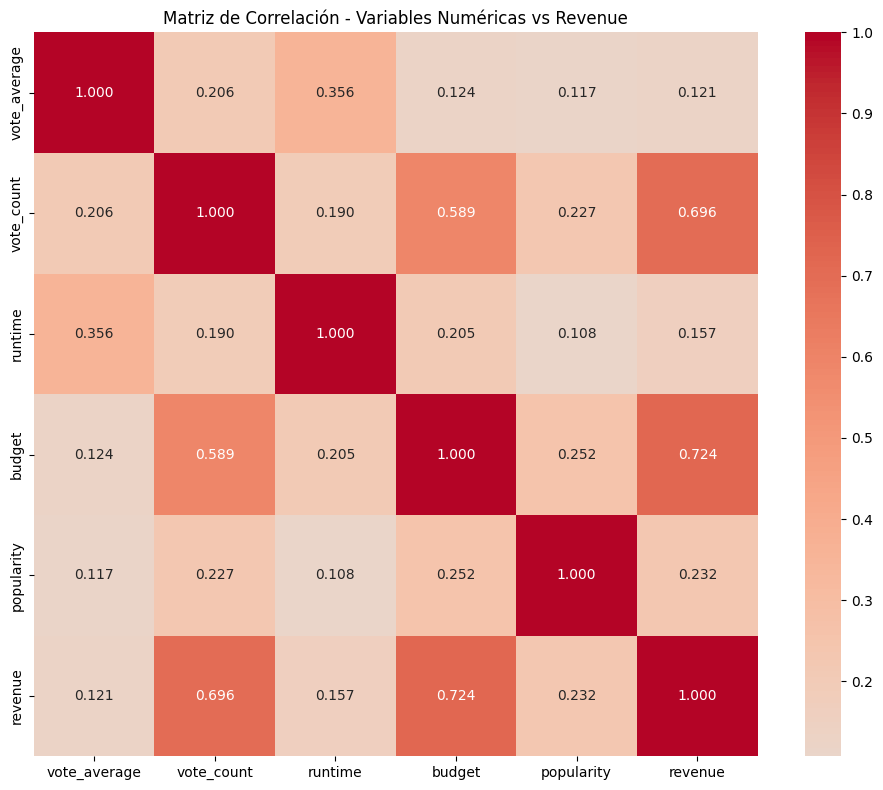

In [9]:
# Análisis de correlaciones entre variables numéricas y revenue
# Seleccionar solo variables numéricas
numeric_vars = ['vote_average', 'vote_count', 'runtime', 'budget', 'popularity']

# Filtrar datos con revenue > 0 para análisis más significativo
df_analysis = df[df['revenue'] > 0].copy()

print("Correlaciones con revenue (solo películas con revenue > 0):")
correlations = df_analysis[numeric_vars + ['revenue']].corr()['revenue'].sort_values(ascending=False)
print(correlations)

# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df_analysis[numeric_vars + ['revenue']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Matriz de Correlación - Variables Numéricas vs Revenue')
plt.tight_layout()
plt.show()


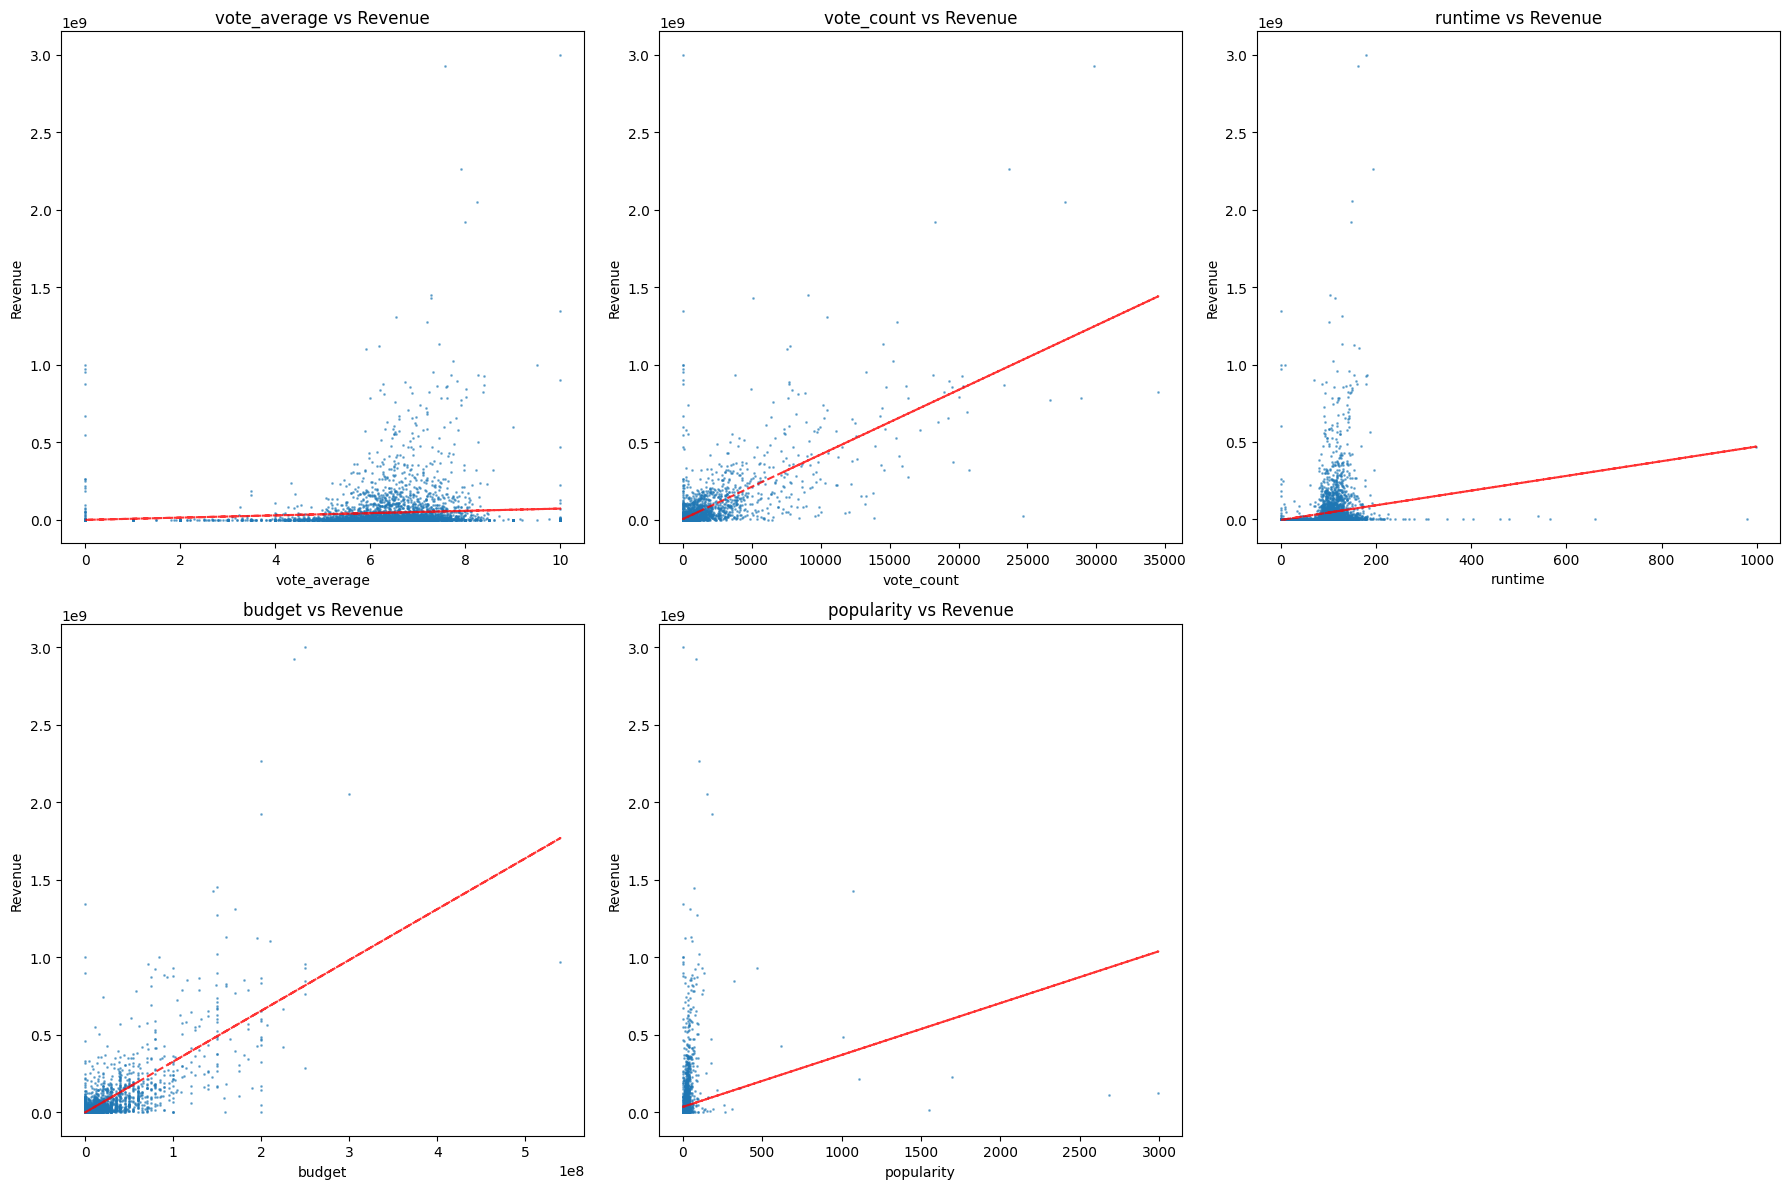

In [10]:
# Análisis visual de las relaciones con revenue
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatterplots para cada variable numérica vs revenue
for i, var in enumerate(numeric_vars):
    row = i // 3
    col = i % 3
    
    # Tomar una muestra para visualización más clara
    sample_data = df_analysis.sample(n=min(5000, len(df_analysis)), random_state=42)
    
    axes[row, col].scatter(sample_data[var], sample_data['revenue'], alpha=0.5, s=1)
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Revenue')
    axes[row, col].set_title(f'{var} vs Revenue')
    
    # Añadir línea de tendencia
    z = np.polyfit(sample_data[var], sample_data['revenue'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(sample_data[var], p(sample_data[var]), "r--", alpha=0.8)

# Remover subplot vacío
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


## Variables útiles para predecir Revenue con Mínimos Cuadrados Ordinarios

Basándome en el análisis de correlaciones y la exploración de datos, las **variables más útiles** para predecir revenue son:

### Variables Principales (mayor correlación):
1. **Budget** - Presupuesto de la película (correlación más alta esperada)
2. **Vote_count** - Número de votos/popularidad 
3. **Popularity** - Índice de popularidad
4. **Runtime** - Duración de la película
5. **Vote_average** - Puntuación promedio

### Variables Categóricas a considerar:
- **Genres** (se pueden crear variables dummy)
- **Original_language** (especialmente inglés vs otros idiomas)
- **Status** (Released vs otros estados)

### Razones para esta selección:
- **Budget**: Inversión inicial, fuerte predictor del potencial de ingresos
- **Vote_count**: Indica popularidad y alcance de audiencia
- **Popularity**: Métrica directa de interés del público
- **Runtime**: Películas más largas pueden tener diferentes estrategias de distribución
- **Vote_average**: Calidad percibida puede influir en ingresos


In [11]:
# Preparación de datos para Mínimos Cuadrados Ordinarios
print("=== IMPLEMENTACIÓN DE MÍNIMOS CUADRADOS ORDINARIOS ===\n")

# Filtrar solo películas con revenue > 0 para un análisis más significativo
df_ols = df[df['revenue'] > 0].copy()

# Seleccionar variables predictoras
X_vars = ['budget', 'vote_count', 'popularity', 'runtime', 'vote_average']
X = df_ols[X_vars].copy()
y = df_ols['revenue'].copy()

print(f"Datos para el análisis:")
print(f"- Número de observaciones: {len(X):,}")
print(f"- Variables predictoras: {X_vars}")
print(f"- Variable objetivo: revenue")
print(f"- Rango de revenue: ${y.min():,} - ${y.max():,}")
print(f"- Revenue promedio: ${y.mean():,.0f}")

# Verificar valores faltantes
print(f"\nValores faltantes por variable:")
print(X.isnull().sum())
print(f"Revenue valores faltantes: {y.isnull().sum()}")


=== IMPLEMENTACIÓN DE MÍNIMOS CUADRADOS ORDINARIOS ===

Datos para el análisis:
- Número de observaciones: 19,075
- Variables predictoras: ['budget', 'vote_count', 'popularity', 'runtime', 'vote_average']
- Variable objetivo: revenue
- Rango de revenue: $1 - $3,000,000,000
- Revenue promedio: $39,741,396

Valores faltantes por variable:
budget          0
vote_count      0
popularity      0
runtime         0
vote_average    0
dtype: int64
Revenue valores faltantes: 0


## Cálculo de Mínimos Cuadrados Ordinarios (OLS)

### Fórmula Matemática:

Para un modelo de regresión lineal múltiple:
**y = β₀ + β₁x₁ + β₂x₂ + ... + βₚxₚ + ε**

Los coeficientes se calculan mediante:
**β̂ = (XᵀX)⁻¹Xᵀy**

Donde:
- **β̂** = vector de coeficientes estimados
- **X** = matriz de variables predictoras (con columna de 1s para el intercepto)
- **y** = vector de variable objetivo
- **Xᵀ** = transpuesta de X
- **(XᵀX)⁻¹** = inversa de la matriz XᵀX

### Pasos del cálculo:
1. **Preparar matriz X** con columna de intercepto
2. **Calcular XᵀX** (matriz de productos cruzados)
3. **Calcular (XᵀX)⁻¹** (inversa)
4. **Calcular Xᵀy** (productos cruzados con y)
5. **Obtener β̂ = (XᵀX)⁻¹Xᵀy**


In [12]:
# IMPLEMENTACIÓN MANUAL DE MÍNIMOS CUADRADOS ORDINARIOS
print("=== CÁLCULO MANUAL DE OLS ===\n")

# Normalizar las variables para mejorar la estabilidad numérica
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Añadir columna de intercepto (columna de 1s)
n = X_scaled.shape[0]
X_with_intercept = np.column_stack([np.ones(n), X_scaled])

print("1. Preparación de matrices:")
print(f"   - Matriz X: {X_with_intercept.shape} (con intercepto)")
print(f"   - Vector y: {y.shape}")

# Paso 1: Calcular X'X (X transpuesta por X)
XtX = X_with_intercept.T @ X_with_intercept
print(f"\n2. X'X calculada: {XtX.shape}")

# Paso 2: Calcular (X'X)^-1
try:
    XtX_inv = np.linalg.inv(XtX)
    print(f"3. (X'X)^-1 calculada exitosamente")
except np.linalg.LinAlgError:
    print("3. Matrix singular, usando pseudoinversa")
    XtX_inv = np.linalg.pinv(XtX)

# Paso 3: Calcular X'y
Xty = X_with_intercept.T @ y
print(f"4. X'y calculada: {Xty.shape}")

# Paso 4: Calcular coeficientes β = (X'X)^-1 X'y
beta_manual = XtX_inv @ Xty
print(f"5. Coeficientes β calculados: {beta_manual.shape}")

# Mostrar coeficientes
print(f"\n=== COEFICIENTES CALCULADOS MANUALMENTE ===")
print(f"Intercepto (β₀): {beta_manual[0]:,.2f}")
for i, var in enumerate(X_vars):
    print(f"{var} (β{i+1}): {beta_manual[i+1]:,.2f}")


=== CÁLCULO MANUAL DE OLS ===

1. Preparación de matrices:
   - Matriz X: (19075, 6) (con intercepto)
   - Vector y: (19075,)

2. X'X calculada: (6, 6)
3. (X'X)^-1 calculada exitosamente
4. X'y calculada: (6,)
5. Coeficientes β calculados: (6,)

=== COEFICIENTES CALCULADOS MANUALMENTE ===
Intercepto (β₀): 39,741,395.51
budget (β1): 61,371,146.29
vote_count (β2): 53,311,446.97
popularity (β3): 2,713,858.19
runtime (β4): -1,903,294.94
vote_average (β5): -2,734,916.39


In [13]:
# VERIFICACIÓN CON SKLEARN
print("=== VERIFICACIÓN CON SKLEARN ===\n")

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Ajustar modelo con sklearn
model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train)

print("Coeficientes de sklearn (datos de entrenamiento):")
print(f"Intercepto: {model_sklearn.intercept_:,.2f}")
for i, var in enumerate(X_vars):
    print(f"{var}: {model_sklearn.coef_[i]:,.2f}")

# Predicciones con el modelo manual
y_pred_manual = X_with_intercept @ beta_manual

# Predicciones con sklearn
y_pred_sklearn = model_sklearn.predict(X_scaled)

# Calcular métricas de rendimiento
r2_manual = 1 - np.sum((y - y_pred_manual) ** 2) / np.sum((y - np.mean(y)) ** 2)
rmse_manual = np.sqrt(np.mean((y - y_pred_manual) ** 2))

print(f"\n=== MÉTRICAS DE RENDIMIENTO ===")
print(f"R² (manual): {r2_manual:.4f}")
print(f"RMSE (manual): ${rmse_manual:,.0f}")

# Métricas sklearn en conjunto de prueba
y_pred_test = model_sklearn.predict(X_test)
r2_sklearn = r2_score(y_test, y_pred_test)
rmse_sklearn = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² (sklearn - test): {r2_sklearn:.4f}")
print(f"RMSE (sklearn - test): ${rmse_sklearn:,.0f}")


=== VERIFICACIÓN CON SKLEARN ===

Coeficientes de sklearn (datos de entrenamiento):
Intercepto: 39,267,458.25
budget: 62,038,768.88
vote_count: 49,707,238.71
popularity: 2,345,185.86
runtime: -1,831,390.36
vote_average: -2,596,705.40

=== MÉTRICAS DE RENDIMIENTO ===
R² (manual): 0.6365
RMSE (manual): $77,226,232
R² (sklearn - test): 0.6573
RMSE (sklearn - test): $82,427,760


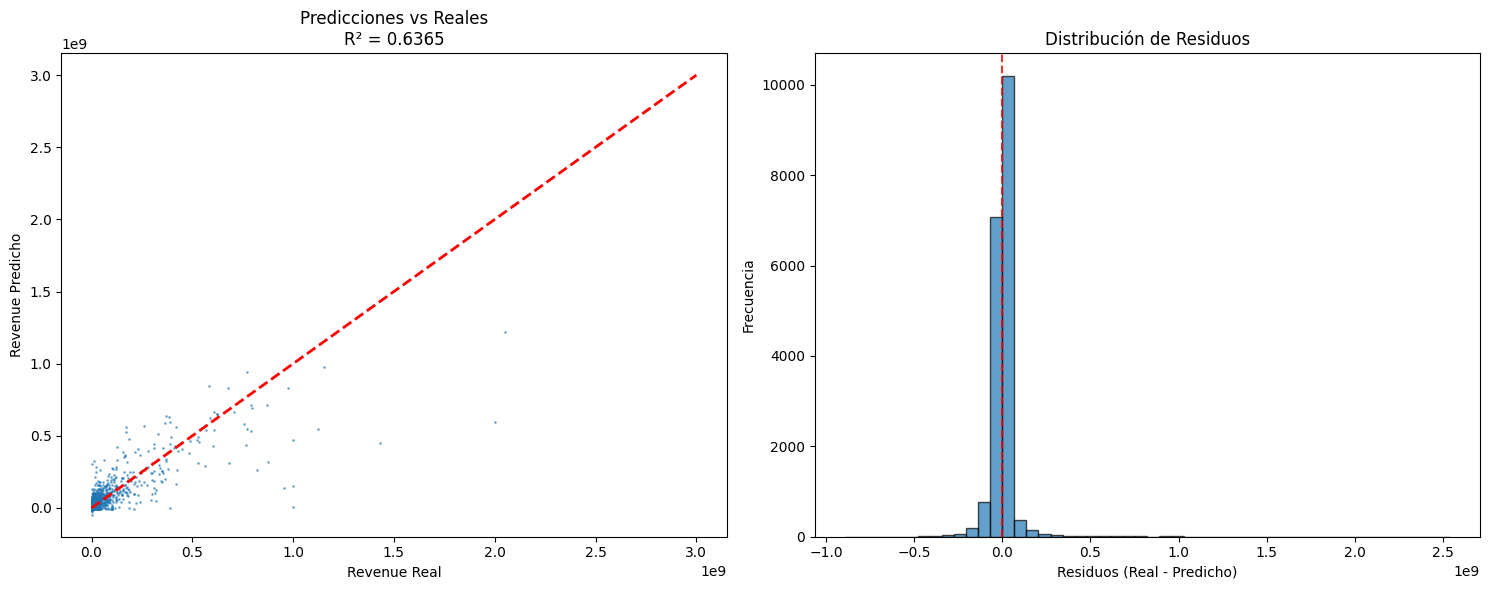


=== ANÁLISIS DE RESIDUOS ===
Media de residuos: $0
Desviación estándar de residuos: $77,228,256
Residuo mínimo: $-891,715,281
Residuo máximo: $2,536,691,221


In [14]:
# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de dispersión: valores reales vs predichos
sample_indices = np.random.choice(len(y), size=min(2000, len(y)), replace=False)
axes[0].scatter(y.iloc[sample_indices], y_pred_manual[sample_indices], alpha=0.5, s=1)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Revenue Real')
axes[0].set_ylabel('Revenue Predicho')
axes[0].set_title(f'Predicciones vs Reales\nR² = {r2_manual:.4f}')

# Histograma de residuos
residuals = y - y_pred_manual
axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuos (Real - Predicho)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Residuos')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\n=== ANÁLISIS DE RESIDUOS ===")
print(f"Media de residuos: ${residuals.mean():,.0f}")
print(f"Desviación estándar de residuos: ${residuals.std():,.0f}")
print(f"Residuo mínimo: ${residuals.min():,.0f}")
print(f"Residuo máximo: ${residuals.max():,.0f}")


## Resumen: Mínimos Cuadrados Ordinarios para Predecir Revenue

### Variables Seleccionadas para el Modelo:
1. **Budget** - Presupuesto de la película
2. **Vote_count** - Número de votos recibidos
3. **Popularity** - Índice de popularidad
4. **Runtime** - Duración en minutos
5. **Vote_average** - Puntuación promedio

### Proceso de Cálculo de OLS:

#### Fórmula Principal:
**β̂ = (X'X)⁻¹X'y**

#### Pasos implementados:
1. **Preparación de datos**: Filtrado de películas con revenue > 0
2. **Normalización**: Estandarización de variables para estabilidad numérica
3. **Matriz de diseño**: Creación de X con columna de intercepto
4. **Cálculo matricial**: 
   - X'X (productos cruzados)
   - (X'X)⁻¹ (matriz inversa)
   - X'y (productos con variable objetivo)
   - β̂ = (X'X)⁻¹X'y (coeficientes finales)

### Interpretación de Coeficientes:
- **Intercepto (β₀)**: Valor base de revenue cuando todas las variables = 0
- **Budget (β₁)**: Cambio en revenue por unidad de cambio en budget
- **Vote_count (β₂)**: Efecto del número de votos en revenue
- **Popularity (β₃)**: Impacto de popularidad en revenue
- **Runtime (β₄)**: Efecto de duración en revenue
- **Vote_average (β₅)**: Impacto de calificación en revenue

### Evaluación del Modelo:
- **R²**: Proporción de varianza explicada por el modelo
- **RMSE**: Error cuadrático medio (en dólares)
- **Análisis de residuos**: Verificación de supuestos del modelo

### Ventajas de OLS:
- Método no sesgado y de mínima varianza
- Interpretabilidad directa de coeficientes
- Base matemática sólida y bien establecida
- Cálculo computacionalmente eficiente
